In [1]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seisbench.data as sbd
import seisbench.generate as sbg
import seisbench.models as sbm
import torch
from obspy import UTCDateTime
from scipy.stats import pearsonr
from sklearn.metrics import (
    auc,
    mean_squared_error,
    precision_recall_curve,
    r2_score,
    roc_curve,
)
from torch.utils.data import DataLoader, Dataset

# Create Dataloader

In [2]:
class IndonesiaDataset(Dataset):
    """Custom Dataset untuk data gempa Indonesia"""

    def __init__(self, base_dir="seismic_data_download_2010_9"):
        self.base_dir = base_dir
        self.picks_df = pd.read_csv(os.path.join(base_dir, "all_picks.csv"))
        self.picks_df["pick_time"] = pd.to_datetime(self.picks_df["pick_time"])
        self.picks_df["event_time"] = pd.to_datetime(self.picks_df["event_time"])

        # Load semua waveform dan label
        self.data = []
        station_dirs = [
            d
            for d in os.listdir(base_dir)
            if os.path.isdir(os.path.join(base_dir, d)) and d != ".ipynb_checkpoints"
        ]  # Ignore checkpoints folder

        for station in station_dirs:
            try:
                waveform_path = os.path.join(base_dir, station, "waveforms.npy")
                labels_path = os.path.join(base_dir, station, "labels.npy")

                if not os.path.exists(waveform_path) or not os.path.exists(labels_path):
                    continue

                waveforms = np.load(waveform_path)
                labels = np.load(labels_path)
                station_picks = self.picks_df[self.picks_df["station"] == station]

                for i in range(len(waveforms)):
                    if i < len(station_picks):
                        self.data.append(
                            {
                                "X": torch.FloatTensor(
                                    waveforms[i]
                                ),  # Convert to tensor here
                                "y": torch.FloatTensor(
                                    labels[i]
                                ),  # Convert to tensor here
                                "station": station,
                                "event_time": station_picks.iloc[i]["event_time"],
                            }
                        )
            except Exception as e:
                print(f"Error loading station {station}: {str(e)}")

        if len(self.data) == 0:
            raise RuntimeError("No valid data found in the dataset")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


def custom_collate(batch):
    """Custom collate function untuk DataLoader"""
    return {
        "X": torch.stack([item["X"] for item in batch]),
        "y": torch.stack([item["y"] for item in batch]),
        "station": [item["station"] for item in batch],
        "event_time": [item["event_time"] for item in batch],
    }


def prepare_experiment():
    """Persiapan untuk eksperimen"""
    # Load dataset
    dataset = IndonesiaDataset()

    # Split data
    total_size = len(dataset)
    train_size = int(0.7 * total_size)
    val_size = int(0.15 * total_size)
    test_size = total_size - train_size - val_size

    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size, test_size]
    )

    return train_dataset, val_dataset, test_dataset


train_dataset, val_dataset, test_dataset = prepare_experiment()

# Metrics

In [13]:
def measure_inference_time(model, test_loader, device="cuda", num_runs=5):
    """Mengukur waktu inferensi model"""
    model = model.to(device)
    model.eval()

    times = []
    batch_sizes = []
    total_samples = 0

    # Warm up GPU
    if device == "cuda":
        for _ in range(10):
            batch = next(iter(test_loader))
            X = batch["X"].float().to(device)

            # Sesuaikan jumlah channels
            if hasattr(model, "base") and model.base == "phasenet":
                if model.input_channels == 4:
                    X = torch.cat((X, torch.zeros_like(X[:, :1, :])), dim=1)

            with torch.no_grad():
                _ = model(X)

    with torch.no_grad():
        for run in range(num_runs):
            batch_times = []
            for batch in test_loader:
                X = batch["X"].float().to(device)

                # Sesuaikan jumlah channels
                if hasattr(model, "base") and model.base == "phasenet":
                    if model.input_channels == 4:
                        X = torch.cat((X, torch.zeros_like(X[:, :1, :])), dim=1)

                batch_size = X.shape[0]

                start_time = time.perf_counter()
                _ = model(X)
                if device == "cuda":
                    torch.cuda.synchronize()  # Tunggu GPU selesai
                end_time = time.perf_counter()

                batch_times.append((end_time - start_time, batch_size))
                total_samples += batch_size

            # Ambil rata-rata waktu per batch untuk run ini
            run_time = sum(t[0] for t in batch_times)
            times.append(run_time)
            batch_sizes.append(sum(t[1] for t in batch_times))

    # Hitung statistik
    avg_time = np.mean(times)
    std_time = np.std(times)
    avg_samples = np.mean(batch_sizes)

    # Hitung throughput (samples per second)
    throughput = avg_samples / avg_time

    return {
        "total_time": avg_time,
        "time_std": std_time,
        "samples_per_second": throughput,
        "total_samples": total_samples // num_runs,
    }


def plot_results(results):
    """Plot perbandingan hasil"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    models = ["Pretrained", "From Scratch", "Fine-tuned"]
    x = np.arange(len(models))
    width = 0.35

    # 1. Error dalam detik
    ax1 = axes[0, 0]
    p_err = [
        np.mean(results[m]["error_seconds"]["P"])
        for m in ["pretrained", "scratch", "finetuned"]
    ]
    s_err = [
        np.mean(results[m]["error_seconds"]["S"])
        for m in ["pretrained", "scratch", "finetuned"]
    ]

    ax1.bar(x - width / 2, p_err, width, label="P-wave")
    ax1.bar(x + width / 2, s_err, width, label="S-wave")
    ax1.set_ylabel("Mean Error (seconds)")
    ax1.set_title("Pick Time Error")
    ax1.set_xticks(x)
    ax1.set_xticklabels(models)
    ax1.legend()

    # 2. Detection Rate
    ax2 = axes[0, 1]
    p_det = [
        results[m]["detection_rate"]["P"]
        for m in ["pretrained", "scratch", "finetuned"]
    ]
    s_det = [
        results[m]["detection_rate"]["S"]
        for m in ["pretrained", "scratch", "finetuned"]
    ]

    ax2.bar(x - width / 2, p_det, width, label="P-wave")
    ax2.bar(x + width / 2, s_det, width, label="S-wave")
    ax2.set_ylabel("Detection Rate (%)")
    ax2.set_title("Phase Detection Rate")
    ax2.set_xticks(x)
    ax2.set_xticklabels(models)
    ax2.legend()

    # 3. Training Loss
    ax3 = axes[1, 0]
    ax3.plot(results["losses"]["scratch"][0], label="Scratch Train")
    ax3.plot(results["losses"]["scratch"][1], label="Scratch Val")
    ax3.plot(results["losses"]["finetuned"][0], label="Finetuned Train")
    ax3.plot(results["losses"]["finetuned"][1], label="Finetuned Val")
    ax3.set_xlabel("Epoch")
    ax3.set_ylabel("Loss")
    ax3.set_title("Training Progress")
    ax3.legend()

    # 4. Inference Speed
    ax4 = axes[1, 1]
    speeds = [
        results["inference_times"][m]["samples_per_second"]
        for m in ["pretrained", "scratch", "finetuned"]
    ]
    ax4.bar(x, speeds)
    ax4.set_ylabel("Samples per Second")
    ax4.set_title("Inference Speed")
    ax4.set_xticks(x)
    ax4.set_xticklabels(models)

    plt.tight_layout()
    plt.show()

    # Save the plot
    fig.savefig("model_comparison_plot.png", dpi=300, bbox_inches="tight")


def export_results_to_csv(results, base_dir="results"):
    """Export semua hasil ke file CSV"""
    os.makedirs(base_dir, exist_ok=True)

    # 1. Export error metrics
    error_data = []
    for model_name in ["pretrained", "scratch", "finetuned"]:
        row = {
            "model": model_name,
            "p_error_mean": np.mean(results[model_name]["error_seconds"]["P"]),
            "p_error_std": np.std(results[model_name]["error_seconds"]["P"]),
            "p_error_median": np.median(results[model_name]["error_seconds"]["P"]),
            "s_error_mean": np.mean(results[model_name]["error_seconds"]["S"]),
            "s_error_std": np.std(results[model_name]["error_seconds"]["S"]),
            "s_error_median": np.median(results[model_name]["error_seconds"]["S"]),
            "p_detection_rate": results[model_name]["detection_rate"]["P"],
            "s_detection_rate": results[model_name]["detection_rate"]["S"],
            "inference_time": results["inference_times"][model_name]["total_time"],
            "inference_speed": results["inference_times"][model_name][
                "samples_per_second"
            ],
        }
        error_data.append(row)

    pd.DataFrame(error_data).to_csv(
        os.path.join(base_dir, "model_comparison.csv"), index=False
    )

    # 2. Export training history
    train_history = {
        "epoch": list(range(1, len(results["losses"]["scratch"][0]) + 1)),
        "scratch_train_loss": results["losses"]["scratch"][0],
        "scratch_val_loss": results["losses"]["scratch"][1],
        "finetuned_train_loss": results["losses"]["finetuned"][0],
        "finetuned_val_loss": results["losses"]["finetuned"][1],
    }
    pd.DataFrame(train_history).to_csv(
        os.path.join(base_dir, "training_history.csv"), index=False
    )

    # 3. Export detail picks untuk setiap model
    for model_name in ["pretrained", "scratch", "finetuned"]:
        picks_data = []
        for phase in ["P", "S"]:
            for error in results[model_name]["error_seconds"][phase]:
                picks_data.append({"phase": phase, "error_seconds": error})

        pd.DataFrame(picks_data).to_csv(
            os.path.join(base_dir, f"{model_name}_picks_detail.csv"), index=False
        )


def export_results_to_csv(results, output_dir, experiment_name="experiment"):
    """
    Export semua hasil ke file CSV
    """
    # Buat timestamp untuk identifikasi unik
    timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")

    # Buat output directory jika belum ada
    os.makedirs(output_dir, exist_ok=True)

    # 1. Export error metrics
    error_data = []
    for model_name in ["pretrained", "scratch", "finetuned"]:
        row = {
            "model": model_name,
            "p_error_mean": np.mean(results[model_name]["error_seconds"]["P"]),
            "p_error_std": np.std(results[model_name]["error_seconds"]["P"]),
            "p_error_median": np.median(results[model_name]["error_seconds"]["P"]),
            "s_error_mean": np.mean(results[model_name]["error_seconds"]["S"]),
            "s_error_std": np.std(results[model_name]["error_seconds"]["S"]),
            "s_error_median": np.median(results[model_name]["error_seconds"]["S"]),
            "p_detection_rate": results[model_name]["detection_rate"]["P"],
            "s_detection_rate": results[model_name]["detection_rate"]["S"],
            "inference_time": results["inference_times"][model_name]["total_time"],
            "inference_speed": results["inference_times"][model_name][
                "samples_per_second"
            ],
        }
        error_data.append(row)

    pd.DataFrame(error_data).to_csv(
        os.path.join(output_dir, f"{experiment_name}_comparison_{timestamp}.csv"),
        index=False,
    )

    # 2. Export training history - scratch model
    train_history_scratch = {
        "epoch": list(range(1, len(results["losses"]["scratch"][0]) + 1)),
        "train_loss": results["losses"]["scratch"][0],
        "val_loss": results["losses"]["scratch"][1],
    }
    pd.DataFrame(train_history_scratch).to_csv(
        os.path.join(output_dir, f"{experiment_name}_scratch_history_{timestamp}.csv"),
        index=False,
    )

    # Export training history - finetuned model
    train_history_finetuned = {
        "epoch": list(range(1, len(results["losses"]["finetuned"][0]) + 1)),
        "train_loss": results["losses"]["finetuned"][0],
        "val_loss": results["losses"]["finetuned"][1],
    }
    pd.DataFrame(train_history_finetuned).to_csv(
        os.path.join(
            output_dir, f"{experiment_name}_finetuned_history_{timestamp}.csv"
        ),
        index=False,
    )

    # 3. Export detail picks untuk setiap model
    for model_name in ["pretrained", "scratch", "finetuned"]:
        picks_data = []
        for phase in ["P", "S"]:
            for error in results[model_name]["error_seconds"][phase]:
                picks_data.append({"phase": phase, "error_seconds": error})

        pd.DataFrame(picks_data).to_csv(
            os.path.join(
                output_dir, f"{experiment_name}_{model_name}_picks_{timestamp}.csv"
            ),
            index=False,
        )

    print(f"Results exported to {output_dir}")

# PhaseNet

In [4]:
def train_model_phasenet(model, train_loader, val_loader, epochs=300, device="cuda"):
    """Training loop dengan loss yang lebih presisi"""
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    def loss_fn(y_pred, y_true, eps=1e-5):
        # Hanya ambil output P dan S dari model (abaikan N)
        y_pred = y_pred[:, :2, :]
        h = y_true * torch.log(y_pred + eps)
        h = h.mean(-1).sum(-1)
        # Debug
        # print(f"y_pred (shape): {y_pred.shape}")
        # print(f"y_pred (values): {y_pred}")
        # print(f"y_true (shape): {y_true.shape}")
        # print(f"y_true (values): {y_true}")
        return -h.mean()

    train_losses = []
    val_losses = []

    model = model.to(device)

    # Untuk tracking best model
    best_val_loss = float("inf")
    epochs_no_improve = 0
    patience = 20  # Early stopping setelah 20 epoch tanpa perbaikan

    for epoch in range(epochs):
        # Training
        model.train()
        epoch_loss = 0
        for batch in train_loader:
            X = batch["X"].float().to(device)
            y = batch["y"].float().to(device)

            pred = model(X)
            loss = loss_fn(pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                X = batch["X"].float().to(device)
                y = batch["y"].float().to(device)

                pred = model(X)
                loss = loss_fn(pred, y)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # Print progress setiap 10 epoch
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}")
            print(f"Train Loss: {avg_train_loss:.8f}")
            print(f"Val Loss: {avg_val_loss:.8f}")
            print("-" * 50)

        # Early stopping
        if epochs_no_improve == patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    return train_losses, val_losses


def evaluate_model_phasenet(model, test_loader, device="cuda"):
    """Evaluasi model dengan metrik yang lebih detail"""
    model = model.to(device)
    model.eval()

    # Untuk error dalam samples
    picks_accuracy = {"P": [], "S": []}
    # Untuk error dalam detik
    picks_time_error = {"P": [], "S": []}
    # Untuk detection rate
    total_events = 0
    detected_events = {"P": 0, "S": 0}

    with torch.no_grad():
        for batch in test_loader:
            X = batch["X"].float().to(device)
            y = batch["y"].float().to(device)

            pred = model(X)
            pred = pred[:, :2, :]

            for i in range(len(X)):
                total_events += 1

                true_p = np.where(y[i, 0].cpu().numpy() == 1)[0]
                true_s = np.where(y[i, 1].cpu().numpy() == 1)[0]

                pred_p = np.where(pred[i, 0].cpu().numpy() > 0.5)[0]
                pred_s = np.where(pred[i, 1].cpu().numpy() > 0.5)[0]

                # Error dalam samples
                if len(true_p) > 0 and len(pred_p) > 0:
                    error_samples = abs(true_p[0] - pred_p[0])
                    picks_accuracy["P"].append(error_samples)
                    picks_time_error["P"].append(
                        error_samples / 100
                    )  # Convert to seconds
                    detected_events["P"] += 1

                if len(true_s) > 0 and len(pred_s) > 0:
                    error_samples = abs(true_s[0] - pred_s[0])
                    picks_accuracy["S"].append(error_samples)
                    picks_time_error["S"].append(
                        error_samples / 100
                    )  # Convert to seconds
                    detected_events["S"] += 1

    return {
        "error_samples": picks_accuracy,
        "error_seconds": picks_time_error,
        "detection_rate": {
            "P": detected_events["P"] / total_events * 100,
            "S": detected_events["S"] / total_events * 100,
        },
        "median_error": {
            "P": np.median(picks_time_error["P"]) if picks_time_error["P"] else None,
            "S": np.median(picks_time_error["S"]) if picks_time_error["S"] else None,
        },
    }


def run_experiment_phasenet(train_dataset, val_dataset, test_dataset, device="cuda"):
    """Menjalankan semua eksperimen"""
    try:
        train_dataset, val_dataset, test_dataset = prepare_experiment()

        batch_size = 32
        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            collate_fn=custom_collate,
        )
        val_loader = DataLoader(
            val_dataset, batch_size=batch_size, collate_fn=custom_collate
        )
        test_loader = DataLoader(
            test_dataset, batch_size=batch_size, collate_fn=custom_collate
        )

        device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Using device: {device}")

        results = {}
        inference_times = {}

        # 1. PhaseNet pretrained tanpa fine-tuning
        print("\nEvaluating pretrained model...")
        model_pretrained = sbm.PhaseNet.from_pretrained("geofon")
        model_pretrained = model_pretrained.to(device)
        pretrained_accuracy = evaluate_model_phasenet(
            model_pretrained, test_loader, device
        )
        inference_times["pretrained"] = measure_inference_time(
            model_pretrained, test_loader, device
        )
        results["pretrained"] = pretrained_accuracy

        # 2. PhaseNet dari awal dengan data Indonesia
        print("\nTraining model from scratch...")
        model_scratch = sbm.PhaseNet(phases="PSN")
        model_scratch = model_scratch.to(device)
        train_losses_scratch, val_losses_scratch = train_model_phasenet(
            model_scratch, train_loader, val_loader, epochs=300, device=device
        )
        scratch_accuracy = evaluate_model_phasenet(model_scratch, test_loader, device)
        inference_times["scratch"] = measure_inference_time(
            model_scratch, test_loader, device
        )
        results["scratch"] = scratch_accuracy
        results["losses"] = {"scratch": (train_losses_scratch, val_losses_scratch)}

        # 3. PhaseNet pretrained dengan fine-tuning
        print("\nFine-tuning pretrained model...")
        model_finetuned = sbm.PhaseNet.from_pretrained("geofon")
        model_finetuned = model_finetuned.to(device)
        train_losses_finetuned, val_losses_finetuned = train_model_phasenet(
            model_finetuned, train_loader, val_loader, epochs=300, device=device
        )
        finetuned_accuracy = evaluate_model_phasenet(
            model_finetuned, test_loader, device
        )
        inference_times["finetuned"] = measure_inference_time(
            model_finetuned, test_loader, device
        )
        results["finetuned"] = finetuned_accuracy
        results["losses"]["finetuned"] = (train_losses_finetuned, val_losses_finetuned)

        # Print inference time comparison
        print("\nInference Time Comparison:")
        print("-" * 50)
        for model_name, timing in inference_times.items():
            print(f"\n{model_name.capitalize()} Model:")
            print(
                f"Total time: {timing['total_time']:.4f} ± {timing['time_std']:.4f} seconds"
            )
            print(f"Samples per second: {timing['samples_per_second']:.2f}")
            print(f"Total samples: {timing['total_samples']}")

        # Save timing results
        results["inference_times"] = inference_times

        return results

    except Exception as e:
        print(f"Error in experiments: {str(e)}")
        raise

Using device: cuda

Evaluating pretrained model...


/home/jovyan/.conda/envs/earthquake-download/lib/python3.11/site-packages/seisbench/models/base.py:489: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_weights = torch.l


Training model from scratch...
Epoch 10/300
Train Loss: 0.00002064
Val Loss: 0.00003332
--------------------------------------------------
Epoch 20/300
Train Loss: 0.00001283
Val Loss: 0.00002702
--------------------------------------------------
Epoch 30/300
Train Loss: 0.00000740
Val Loss: 0.00002071
--------------------------------------------------
Epoch 40/300
Train Loss: 0.00000480
Val Loss: 0.00002265
--------------------------------------------------
Early stopping triggered after 48 epochs

Fine-tuning pretrained model...


/home/jovyan/.conda/envs/earthquake-download/lib/python3.11/site-packages/seisbench/models/base.py:489: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_weights = torch.l

Epoch 10/300
Train Loss: 0.00003814
Val Loss: 0.00004430
--------------------------------------------------
Epoch 20/300
Train Loss: 0.00002451
Val Loss: 0.00003748
--------------------------------------------------
Epoch 30/300
Train Loss: 0.00001663
Val Loss: 0.00003699
--------------------------------------------------
Epoch 40/300
Train Loss: 0.00001733
Val Loss: 0.00004040
--------------------------------------------------
Epoch 50/300
Train Loss: 0.00001630
Val Loss: 0.00003374
--------------------------------------------------
Epoch 60/300
Train Loss: 0.00001075
Val Loss: 0.00003296
--------------------------------------------------
Early stopping triggered after 62 epochs

Inference Time Comparison:
--------------------------------------------------

Pretrained Model:
Total time: 0.0576 ± 0.0004 seconds
Samples per second: 1943.82
Total samples: 112

Scratch Model:
Total time: 0.0586 ± 0.0006 seconds
Samples per second: 1911.89
Total samples: 112

Finetuned Model:
Total time: 0

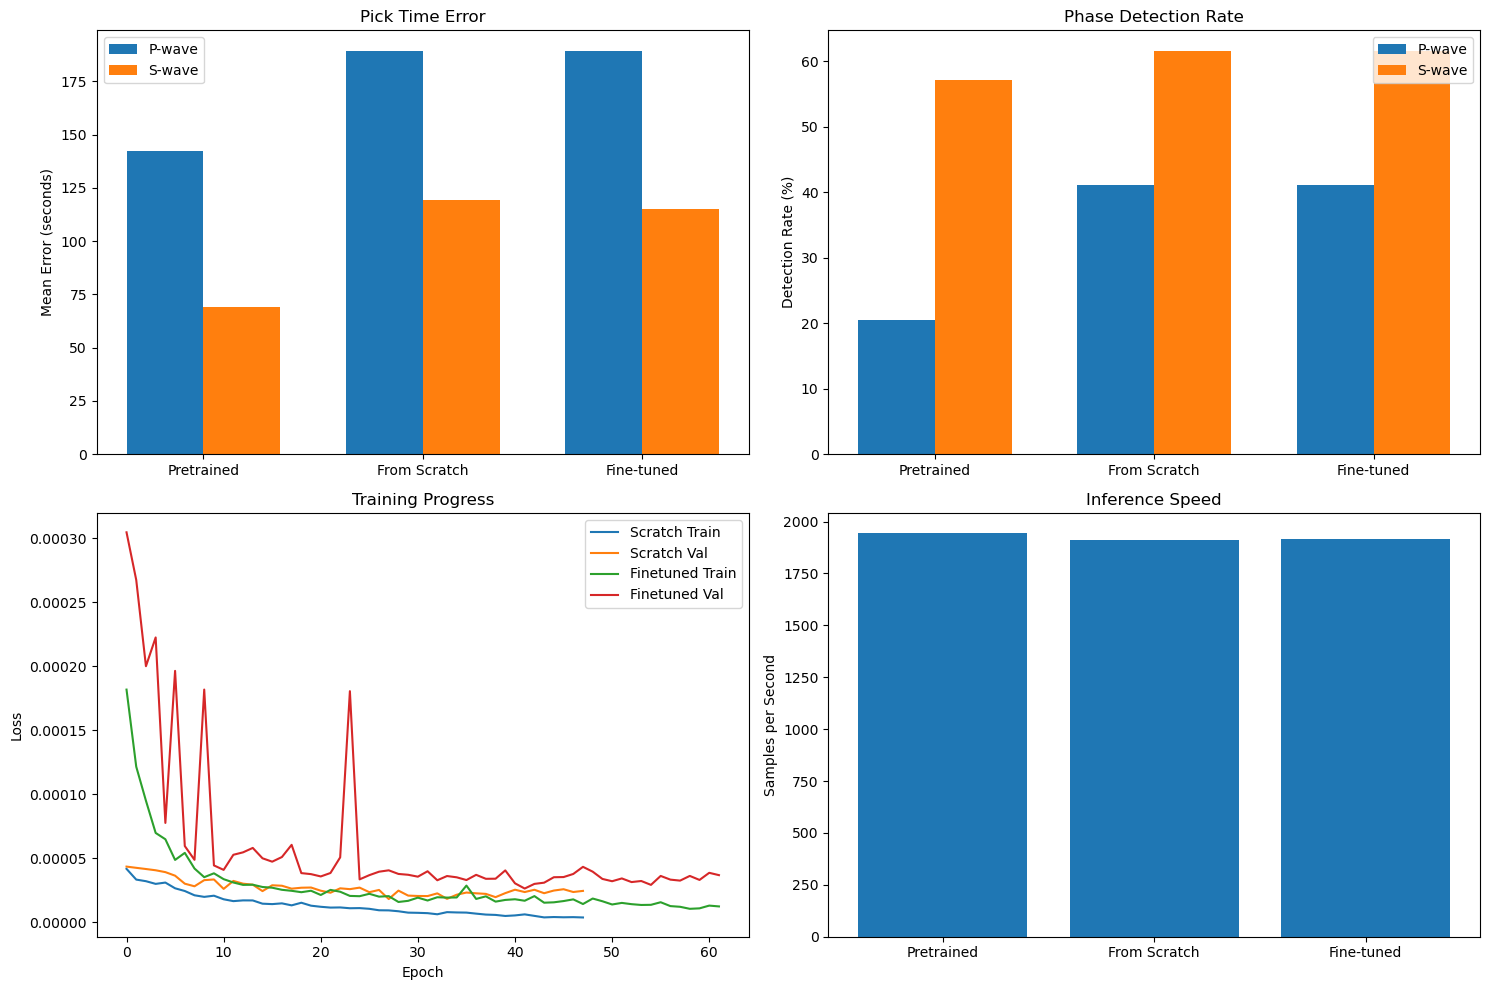

Results exported to output/phasenet


In [5]:
# Jalankan eksperimen PhaseNet
results_phasenet = run_experiment_phasenet(train_dataset, val_dataset, test_dataset)
plot_results(results_phasenet)
export_results_to_csv(
    results=results_phasenet, output_dir="output/phasenet", experiment_name="phasenet"
)

# VariableLengthPhaseNet

In [6]:
from seisbench.models import VariableLengthPhaseNet

# Path ke file pretrained
model_path = "models/geofon/geofon"

# Muat model dengan `load`
model_pretrained = VariableLengthPhaseNet.load(path=model_path)

/home/jovyan/.conda/envs/earthquake-download/lib/python3.11/site-packages/seisbench/models/base.py:489: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_weights = torch.l

In [7]:
def train_model_vlphasenet(model, train_loader, val_loader, epochs=300, device="cuda"):
    """Training loop untuk VariableLengthPhaseNet"""
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    def loss_fn(y_pred, y_true, eps=1e-5):
        y_pred = y_pred[:, :2, :]
        h = y_true * torch.log(y_pred + eps)
        h = h.mean(-1).sum(-1)
        return -h.mean()

    train_losses = []
    val_losses = []

    model = model.to(device)
    best_val_loss = float("inf")
    epochs_no_improve = 0
    patience = 20

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch in train_loader:
            X = batch["X"].float().to(device)
            y = batch["y"].float().to(device)

            pred = model(X)
            loss = loss_fn(pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                X = batch["X"].float().to(device)
                y = batch["y"].float().to(device)

                pred = model(X)
                loss = loss_fn(pred, y)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}")
            print(f"Train Loss: {avg_train_loss:.8f}")
            print(f"Val Loss: {avg_val_loss:.8f}")
            print("-" * 50)

        if epochs_no_improve == patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    return train_losses, val_losses


def evaluate_model_vlphasenet(model, test_loader, device="cuda"):
    """Evaluasi model VariableLengthPhaseNet"""
    model = model.to(device)
    model.eval()

    picks_accuracy = {"P": [], "S": []}
    picks_time_error = {"P": [], "S": []}
    total_events = 0
    detected_events = {"P": 0, "S": 0}

    with torch.no_grad():
        for batch in test_loader:
            X = batch["X"].float().to(device)
            y = batch["y"].float().to(device)

            pred = model(X)
            pred = pred[:, :2, :]

            for i in range(len(X)):
                total_events += 1

                true_p = np.where(y[i, 0].cpu().numpy() == 1)[0]
                true_s = np.where(y[i, 1].cpu().numpy() == 1)[0]

                pred_p = np.where(pred[i, 0].cpu().numpy() > 0.5)[0]
                pred_s = np.where(pred[i, 1].cpu().numpy() > 0.5)[0]

                if len(true_p) > 0 and len(pred_p) > 0:
                    error_samples = abs(true_p[0] - pred_p[0])
                    picks_accuracy["P"].append(error_samples)
                    picks_time_error["P"].append(error_samples / 100)
                    detected_events["P"] += 1

                if len(true_s) > 0 and len(pred_s) > 0:
                    error_samples = abs(true_s[0] - pred_s[0])
                    picks_accuracy["S"].append(error_samples)
                    picks_time_error["S"].append(error_samples / 100)
                    detected_events["S"] += 1

    return {
        "error_samples": picks_accuracy,
        "error_seconds": picks_time_error,
        "detection_rate": {
            "P": detected_events["P"] / total_events * 100,
            "S": detected_events["S"] / total_events * 100,
        },
        "median_error": {
            "P": np.median(picks_time_error["P"]) if picks_time_error["P"] else None,
            "S": np.median(picks_time_error["S"]) if picks_time_error["S"] else None,
        },
    }


def run_experiment_vlphasenet(
    train_dataset, val_dataset, test_dataset, device="cuda", model_path="models/geofon"
):
    """Menjalankan eksperimen dengan VariableLengthPhaseNet"""
    try:
        batch_size = 32
        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            collate_fn=custom_collate,
        )
        val_loader = DataLoader(
            val_dataset, batch_size=batch_size, collate_fn=custom_collate
        )
        test_loader = DataLoader(
            test_dataset, batch_size=batch_size, collate_fn=custom_collate
        )

        device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Using device: {device}")

        results = {}
        inference_times = {}

        # 1. VariableLengthPhaseNet pretrained tanpa fine-tuning
        print("\nEvaluating pretrained model...")
        model_pretrained = sbm.VariableLengthPhaseNet.load(path=model_path)
        model_pretrained = model_pretrained.to(device)
        pretrained_accuracy = evaluate_model_vlphasenet(
            model_pretrained, test_loader, device
        )
        inference_times["pretrained"] = measure_inference_time(
            model_pretrained, test_loader, device
        )
        results["pretrained"] = pretrained_accuracy

        # 2. VariableLengthPhaseNet dari awal dengan data Indonesia
        print("\nTraining model from scratch...")
        # Dapatkan sample_data untuk mengetahui ukuran input
        sample_data = next(iter(train_loader))
        in_samples = sample_data["X"].shape[-1]

        model_scratch = sbm.VariableLengthPhaseNet(
            in_samples=in_samples, phases="PSN", sampling_rate=100, norm="peak"
        )
        model_scratch = model_scratch.to(device)
        train_losses_scratch, val_losses_scratch = train_model_vlphasenet(
            model_scratch, train_loader, val_loader, epochs=300, device=device
        )
        scratch_accuracy = evaluate_model_vlphasenet(model_scratch, test_loader, device)
        inference_times["scratch"] = measure_inference_time(
            model_scratch, test_loader, device
        )
        results["scratch"] = scratch_accuracy
        results["losses"] = {"scratch": (train_losses_scratch, val_losses_scratch)}

        # 3. VariableLengthPhaseNet pretrained dengan fine-tuning
        print("\nFine-tuning pretrained model...")
        model_finetuned = sbm.VariableLengthPhaseNet.load(path=model_path)
        model_finetuned = model_finetuned.to(device)
        train_losses_finetuned, val_losses_finetuned = train_model_vlphasenet(
            model_finetuned, train_loader, val_loader, epochs=300, device=device
        )
        finetuned_accuracy = evaluate_model_vlphasenet(
            model_finetuned, test_loader, device
        )
        inference_times["finetuned"] = measure_inference_time(
            model_finetuned, test_loader, device
        )
        results["finetuned"] = finetuned_accuracy
        results["losses"]["finetuned"] = (train_losses_finetuned, val_losses_finetuned)

        # Print inference time comparison
        print("\nInference Time Comparison:")
        print("-" * 50)
        for model_name, timing in inference_times.items():
            print(f"\n{model_name.capitalize()} Model:")
            print(
                f"Total time: {timing['total_time']:.4f} ± {timing['time_std']:.4f} seconds"
            )
            print(f"Samples per second: {timing['samples_per_second']:.2f}")
            print(f"Total samples: {timing['total_samples']}")

        # Save models dan results
        torch.save(model_scratch.state_dict(), "vlphasenet_scratch.pth")
        torch.save(model_finetuned.state_dict(), "vlphasenet_finetuned.pth")
        results["inference_times"] = inference_times

        return results

    except Exception as e:
        print(f"Error in experiments: {str(e)}")
        raise

Using device: cuda

Evaluating pretrained model...

Training model from scratch...
Epoch 10/300
Train Loss: 0.00001572
Val Loss: 0.00002329
--------------------------------------------------
Epoch 20/300
Train Loss: 0.00000969
Val Loss: 0.00002125
--------------------------------------------------
Epoch 30/300
Train Loss: 0.00000698
Val Loss: 0.00001963
--------------------------------------------------
Epoch 40/300
Train Loss: 0.00000564
Val Loss: 0.00002419
--------------------------------------------------
Early stopping triggered after 42 epochs

Fine-tuning pretrained model...
Epoch 10/300
Train Loss: 0.00003727
Val Loss: 0.00004562
--------------------------------------------------
Epoch 20/300
Train Loss: 0.00002388
Val Loss: 0.00003748
--------------------------------------------------
Epoch 30/300
Train Loss: 0.00001801
Val Loss: 0.00002589
--------------------------------------------------
Epoch 40/300
Train Loss: 0.00001571
Val Loss: 0.00003501
------------------------------

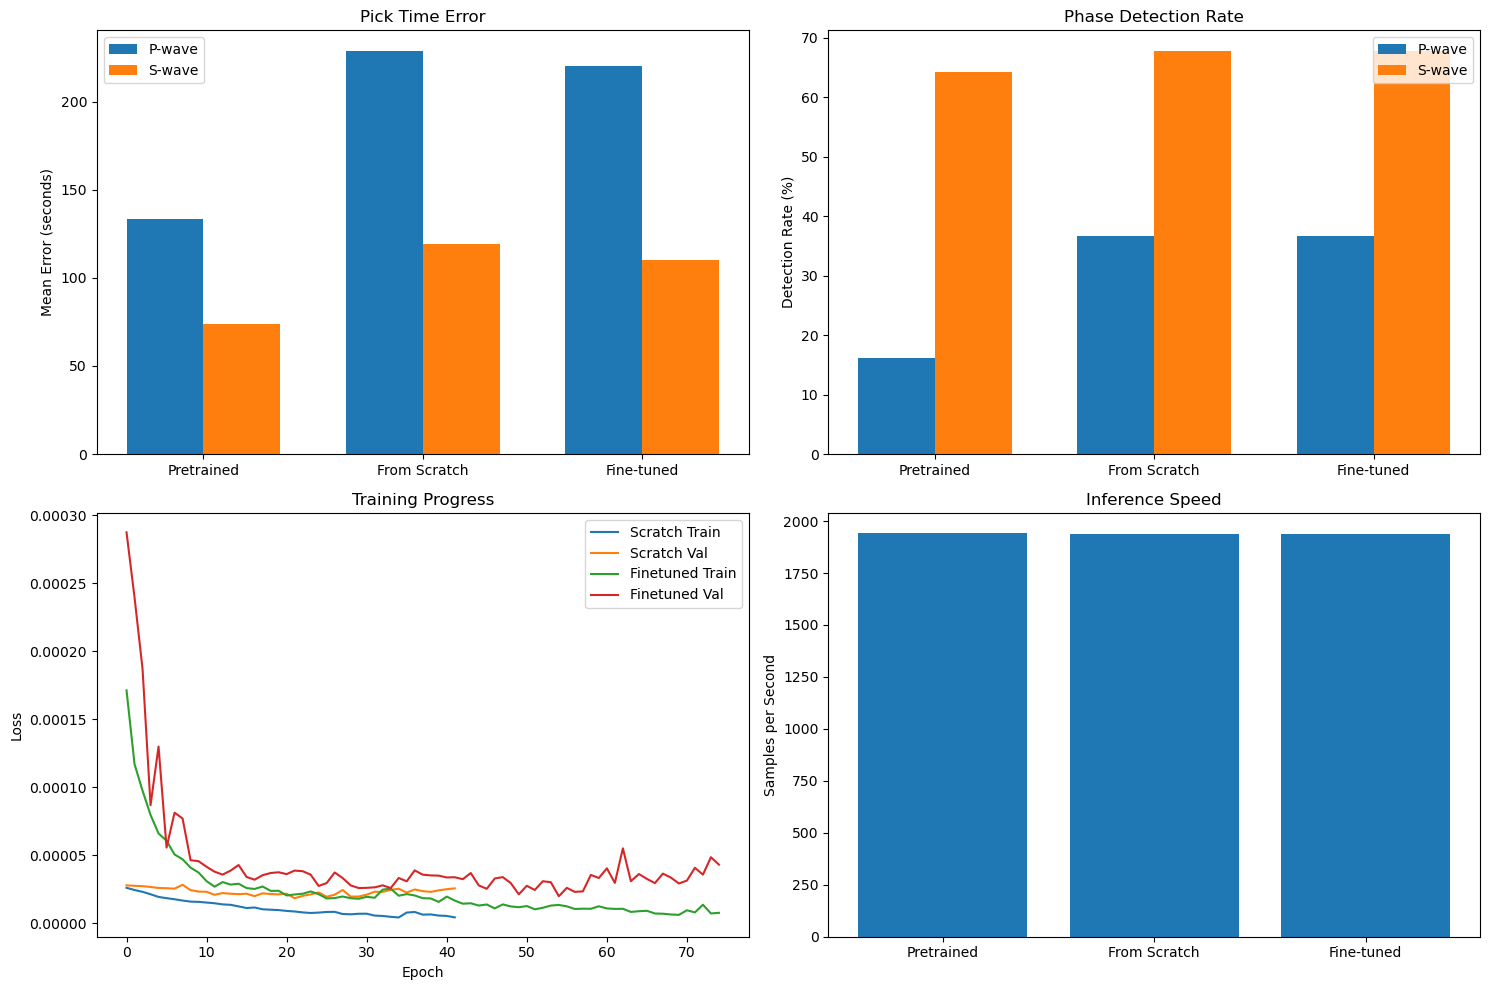

Results exported to output/vlphasenet


In [8]:
# Run experiment
results_vlpn = run_experiment_vlphasenet(
    train_dataset,
    val_dataset,
    test_dataset,
    model_path="models/geofon/geofon",  # Sesuaikan dengan path model Anda
)

# Plot dan export results
plot_results(results_vlpn)
export_results_to_csv(
    results=results_vlpn, output_dir="output/vlphasenet", experiment_name="vlphasenet"
)

# LFEDetect

In [9]:
def train_model_lfedetect(model, train_loader, val_loader, epochs=300, device="cuda"):
    """Training loop untuk LFEDetect"""
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    def loss_fn(y_pred, y_true, eps=1e-5):
        # LFEDetect menggunakan binary cross entropy loss
        y_pred = y_pred[:, :2, :]  # Ambil hanya P dan S
        y_pred = torch.clamp(y_pred, eps, 1 - eps)  # Prevent log(0)
        bce = -(y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred))
        return bce.mean()

    train_losses = []
    val_losses = []

    model = model.to(device)
    best_val_loss = float("inf")
    epochs_no_improve = 0
    patience = 20

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch in train_loader:
            X = batch["X"].float().to(device)
            y = batch["y"].float().to(device)

            pred = model(X)
            loss = loss_fn(pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                X = batch["X"].float().to(device)
                y = batch["y"].float().to(device)

                pred = model(X)
                loss = loss_fn(pred, y)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}")
            print(f"Train Loss: {avg_train_loss:.8f}")
            print(f"Val Loss: {avg_val_loss:.8f}")
            print("-" * 50)

        if epochs_no_improve == patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    return train_losses, val_losses


def evaluate_model_lfedetect(model, test_loader, device="cuda"):
    """Evaluasi model LFEDetect"""
    model = model.to(device)
    model.eval()

    picks_accuracy = {"P": [], "S": []}
    picks_time_error = {"P": [], "S": []}
    total_events = 0
    detected_events = {"P": 0, "S": 0}

    # Threshold khusus untuk LFE
    threshold = 0.1

    with torch.no_grad():
        for batch in test_loader:
            X = batch["X"].float().to(device)
            y = batch["y"].float().to(device)

            pred = model(X)
            pred = pred[:, :2, :]  # Ambil hanya P dan S

            for i in range(len(X)):
                total_events += 1

                true_p = np.where(y[i, 0].cpu().numpy() == 1)[0]
                true_s = np.where(y[i, 1].cpu().numpy() == 1)[0]

                pred_p = np.where(pred[i, 0].cpu().numpy() > threshold)[0]
                pred_s = np.where(pred[i, 1].cpu().numpy() > threshold)[0]

                if len(true_p) > 0 and len(pred_p) > 0:
                    error_samples = abs(true_p[0] - pred_p[0])
                    picks_accuracy["P"].append(error_samples)
                    picks_time_error["P"].append(error_samples / 100)
                    detected_events["P"] += 1

                if len(true_s) > 0 and len(pred_s) > 0:
                    error_samples = abs(true_s[0] - pred_s[0])
                    picks_accuracy["S"].append(error_samples)
                    picks_time_error["S"].append(error_samples / 100)
                    detected_events["S"] += 1

    return {
        "error_samples": picks_accuracy,
        "error_seconds": picks_time_error,
        "detection_rate": {
            "P": detected_events["P"] / total_events * 100,
            "S": detected_events["S"] / total_events * 100,
        },
        "median_error": {
            "P": np.median(picks_time_error["P"]) if picks_time_error["P"] else None,
            "S": np.median(picks_time_error["S"]) if picks_time_error["S"] else None,
        },
    }


def run_experiment_lfedetect(train_dataset, val_dataset, test_dataset, device="cuda"):
    """Menjalankan eksperimen dengan LFEDetect"""
    try:
        batch_size = 32
        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            collate_fn=custom_collate,
        )
        val_loader = DataLoader(
            val_dataset, batch_size=batch_size, collate_fn=custom_collate
        )
        test_loader = DataLoader(
            test_dataset, batch_size=batch_size, collate_fn=custom_collate
        )

        device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Using device: {device}")

        results = {}
        inference_times = {}

        # 1. LFEDetect pretrained tanpa fine-tuning
        print("\nEvaluating pretrained model...")
        model_pretrained = sbm.LFEDetect.from_pretrained("nankai")
        model_pretrained = model_pretrained.to(device)
        pretrained_accuracy = evaluate_model_lfedetect(
            model_pretrained, test_loader, device
        )
        inference_times["pretrained"] = measure_inference_time(
            model_pretrained, test_loader, device
        )
        results["pretrained"] = pretrained_accuracy

        # 2. LFEDetect dari awal dengan data Indonesia
        print("\nTraining model from scratch...")
        # Dapatkan sample_data untuk mengetahui ukuran input
        sample_data = next(iter(train_loader))
        in_samples = sample_data["X"].shape[-1]

        model_scratch = sbm.LFEDetect(
            in_channels=3,  # Z,N,E
            phases="PS",  # P dan S wave
            sampling_rate=100,  # Sesuai data kita
        )
        model_scratch = model_scratch.to(device)
        train_losses_scratch, val_losses_scratch = train_model_lfedetect(
            model_scratch, train_loader, val_loader, epochs=300, device=device
        )
        scratch_accuracy = evaluate_model_lfedetect(model_scratch, test_loader, device)
        inference_times["scratch"] = measure_inference_time(
            model_scratch, test_loader, device
        )
        results["scratch"] = scratch_accuracy
        results["losses"] = {"scratch": (train_losses_scratch, val_losses_scratch)}

        # 3. LFEDetect pretrained dengan fine-tuning
        print("\nFine-tuning pretrained model...")
        model_finetuned = sbm.LFEDetect.from_pretrained("nankai")
        model_finetuned = model_finetuned.to(device)
        train_losses_finetuned, val_losses_finetuned = train_model_lfedetect(
            model_finetuned, train_loader, val_loader, epochs=300, device=device
        )
        finetuned_accuracy = evaluate_model_lfedetect(
            model_finetuned, test_loader, device
        )
        inference_times["finetuned"] = measure_inference_time(
            model_finetuned, test_loader, device
        )
        results["finetuned"] = finetuned_accuracy
        results["losses"]["finetuned"] = (train_losses_finetuned, val_losses_finetuned)

        # Print inference time comparison
        print("\nInference Time Comparison:")
        print("-" * 50)
        for model_name, timing in inference_times.items():
            print(f"\n{model_name.capitalize()} Model:")
            print(
                f"Total time: {timing['total_time']:.4f} ± {timing['time_std']:.4f} seconds"
            )
            print(f"Samples per second: {timing['samples_per_second']:.2f}")
            print(f"Total samples: {timing['total_samples']}")

        # Save models dan results
        torch.save(model_scratch.state_dict(), "lfedetect_scratch.pth")
        torch.save(model_finetuned.state_dict(), "lfedetect_finetuned.pth")
        results["inference_times"] = inference_times

        return results

    except Exception as e:
        print(f"Error in experiments: {str(e)}")
        raise

Using device: cuda

Evaluating pretrained model...


/home/jovyan/.conda/envs/earthquake-download/lib/python3.11/site-packages/seisbench/models/base.py:489: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_weights = torch.l


Training model from scratch...
Epoch 10/300
Train Loss: 0.09677635
Val Loss: 0.07678153
--------------------------------------------------
Epoch 20/300
Train Loss: 0.02873100
Val Loss: 0.03123290
--------------------------------------------------
Epoch 30/300
Train Loss: 0.01198417
Val Loss: 0.00932124
--------------------------------------------------
Epoch 40/300
Train Loss: 0.00657617
Val Loss: 0.00866657
--------------------------------------------------
Epoch 50/300
Train Loss: 0.00403833
Val Loss: 0.00532128
--------------------------------------------------
Epoch 60/300
Train Loss: 0.00261975
Val Loss: 0.00387595
--------------------------------------------------
Epoch 70/300
Train Loss: 0.00190580
Val Loss: 0.00171092
--------------------------------------------------
Epoch 80/300
Train Loss: 0.00144706
Val Loss: 0.00206656
--------------------------------------------------
Epoch 90/300
Train Loss: 0.00114209
Val Loss: 0.00167850
-----------------------------------------------

/home/jovyan/.conda/envs/earthquake-download/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jovyan/.conda/envs/earthquake-download/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


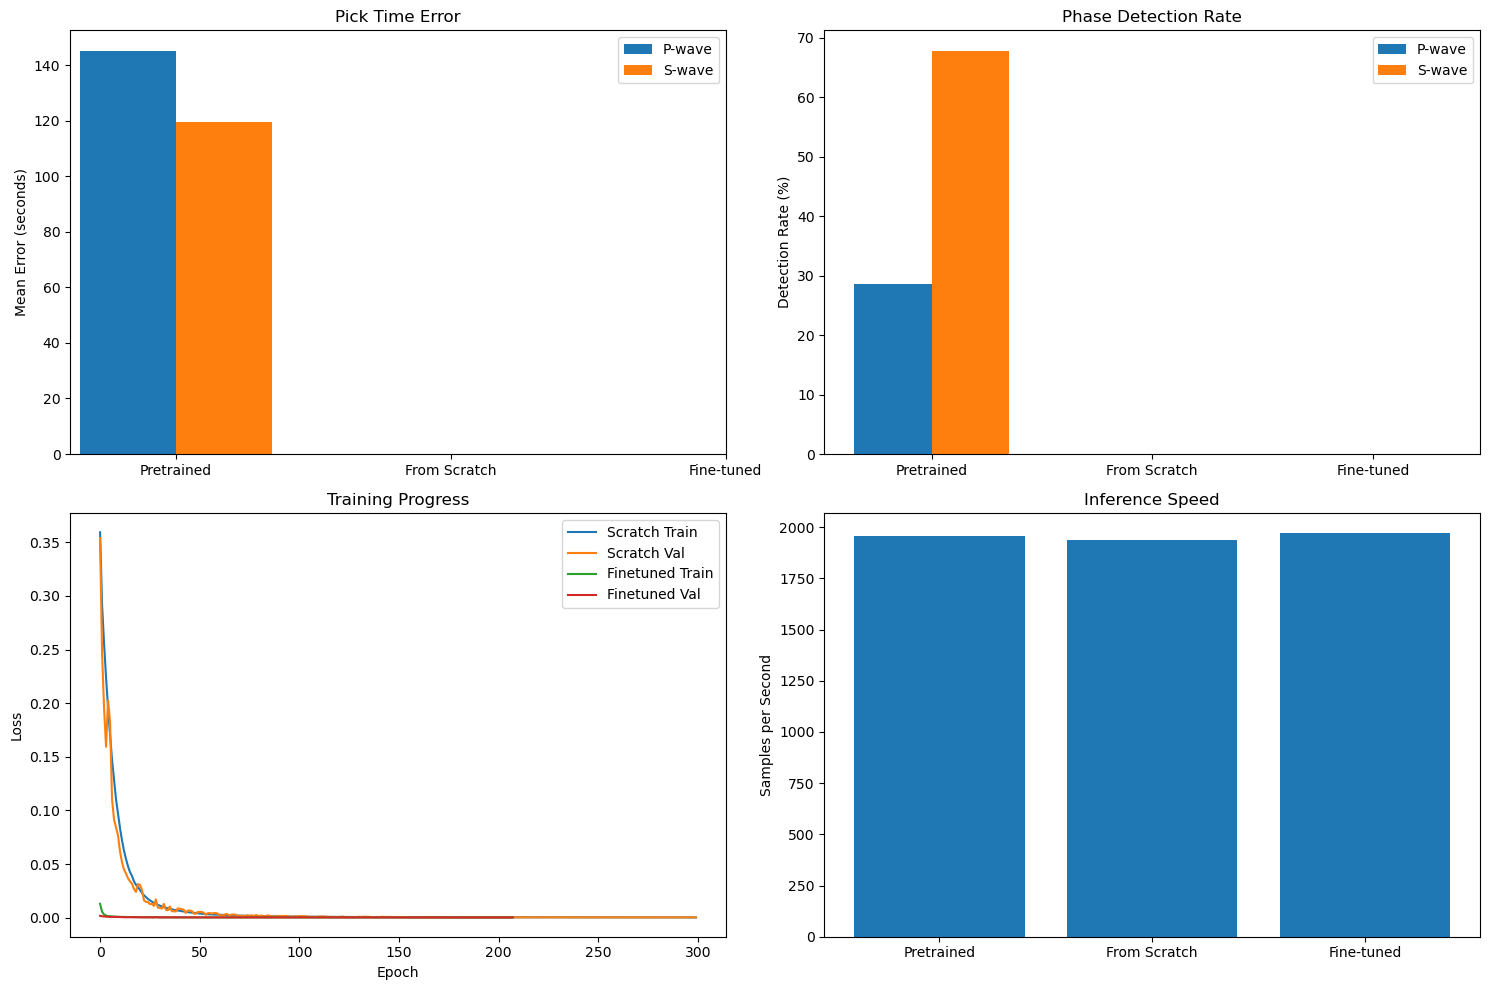

Results exported to output/lfedetect


/home/jovyan/.conda/envs/earthquake-download/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jovyan/.conda/envs/earthquake-download/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/jovyan/.conda/envs/earthquake-download/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jovyan/.conda/envs/earthquake-download/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/jovyan/.conda/envs/earthquake-download/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret 

In [10]:
# Run experiment
results_lfe = run_experiment_lfedetect(train_dataset, val_dataset, test_dataset)

# Plot dan export results
plot_results(results_lfe)
export_results_to_csv(
    results=results_lfe, output_dir="output/lfedetect", experiment_name="lfedetect"
)

# PickBlue

In [14]:
def train_model_pickblue(model, train_loader, val_loader, epochs=300, device="cuda"):
    """Training loop untuk PickBlue"""
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    def loss_fn(y_pred, y_true, eps=1e-5):
        # Cross entropy loss untuk P dan S
        y_pred = y_pred[:, :2, :]  # Ambil P dan S
        y_pred = torch.softmax(y_pred, dim=1)
        h = y_true * torch.log(y_pred + eps)
        h = h.mean(-1).sum(-1)
        return -h.mean()

    train_losses = []
    val_losses = []

    model = model.to(device)
    best_val_loss = float("inf")
    epochs_no_improve = 0
    patience = 20

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch in train_loader:
            X = batch["X"].float().to(device)
            y = batch["y"].float().to(device)

            # Sesuaikan jumlah channels berdasarkan jenis model
            if hasattr(model, "base") and model.base == "phasenet":
                if model.input_channels == 3:
                    X = X[:, :3, :]  # Hapus channel tambahan jika pretrained
                elif model.input_channels == 4:
                    X = torch.cat((X, torch.zeros_like(X[:, :1, :])), dim=1)  # Tambahkan channel dummy
            

            pred = model(X)
            loss = loss_fn(pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                X = batch["X"].float().to(device)
                y = batch["y"].float().to(device)

                # Sesuaikan jumlah channels berdasarkan jenis model
                if hasattr(model, "base") and model.base == "phasenet":
                    if model.input_channels == 3:
                        X = X[:, :3, :]  # Hapus channel tambahan jika pretrained
                    elif model.input_channels == 4:
                        X = torch.cat((X, torch.zeros_like(X[:, :1, :])), dim=1)  # Tambahkan channel dummy


                pred = model(X)
                loss = loss_fn(pred, y)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}")
            print(f"Train Loss: {avg_train_loss:.8f}")
            print(f"Val Loss: {avg_val_loss:.8f}")
            print("-" * 50)

        if epochs_no_improve == patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    return train_losses, val_losses


def evaluate_model_pickblue(model, test_loader, device="cuda"):
    """Evaluasi model PickBlue"""
    model = model.to(device)
    model.eval()

    picks_accuracy = {"P": [], "S": []}
    picks_time_error = {"P": [], "S": []}
    total_events = 0
    detected_events = {"P": 0, "S": 0}

    with torch.no_grad():
        for batch in test_loader:
            X = batch["X"].float().to(device)
            y = batch["y"].float().to(device)

            # Sesuaikan jumlah channels berdasarkan jenis model
            if hasattr(model, "base") and model.base == "phasenet":
                if model.input_channels == 3:
                    X = X[:, :3, :]  # Hapus channel tambahan jika pretrained
                elif model.input_channels == 4:
                    X = torch.cat((X, torch.zeros_like(X[:, :1, :])), dim=1)  # Tambahkan channel dummy


            pred = model(X)
            pred = pred[:, :2, :]  # Ambil P dan S predictions
            pred = torch.softmax(pred, dim=1)

            for i in range(len(X)):
                total_events += 1

                true_p = np.where(y[i, 0].cpu().numpy() == 1)[0]
                true_s = np.where(y[i, 1].cpu().numpy() == 1)[0]

                pred_p = np.where(pred[i, 0].cpu().numpy() > 0.3)[0]
                pred_s = np.where(pred[i, 1].cpu().numpy() > 0.3)[0]

                if len(true_p) > 0 and len(pred_p) > 0:
                    error_samples = abs(true_p[0] - pred_p[0])
                    picks_accuracy["P"].append(error_samples)
                    picks_time_error["P"].append(error_samples / 100)
                    detected_events["P"] += 1

                if len(true_s) > 0 and len(pred_s) > 0:
                    error_samples = abs(true_s[0] - pred_s[0])
                    picks_accuracy["S"].append(error_samples)
                    picks_time_error["S"].append(error_samples / 100)
                    detected_events["S"] += 1

    return {
        "error_samples": picks_accuracy,
        "error_seconds": picks_time_error,
        "detection_rate": {
            "P": detected_events["P"] / total_events * 100,
            "S": detected_events["S"] / total_events * 100,
        },
        "median_error": {
            "P": np.median(picks_time_error["P"]) if picks_time_error["P"] else None,
            "S": np.median(picks_time_error["S"]) if picks_time_error["S"] else None,
        },
    }


def run_experiment_pickblue(train_dataset, val_dataset, test_dataset, device="cuda"):
    """Menjalankan eksperimen dengan PickBlue (berbasis PhaseNet)"""
    try:
        batch_size = 32
        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            collate_fn=custom_collate,
        )
        val_loader = DataLoader(
            val_dataset, batch_size=batch_size, collate_fn=custom_collate
        )
        test_loader = DataLoader(
            test_dataset, batch_size=batch_size, collate_fn=custom_collate
        )

        device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Using device: {device}")

        results = {}
        inference_times = {}

        # 1. PickBlue pretrained tanpa fine-tuning
        print("\nEvaluating pretrained model...")
        model_pretrained = sbm.PickBlue(base="phasenet").from_pretrained("original")
        model_pretrained.base = "phasenet"  # Tambahkan properti base
        model_pretrained.input_channels = 3  # Tentukan jumlah input channels
        model_pretrained = model_pretrained.to(device)
        pretrained_accuracy = evaluate_model_pickblue(
            model_pretrained, test_loader, device
        )
        inference_times["pretrained"] = measure_inference_time(
            model_pretrained, test_loader, device
        )
        results["pretrained"] = pretrained_accuracy

        # 2. PickBlue dari awal dengan data Indonesia
        print("\nTraining model from scratch...")
        model_scratch = sbm.PickBlue(base="phasenet")
        model_scratch.base = "phasenet"  # Tambahkan properti base
        model_scratch.input_channels = 4  # Tentukan jumlah input channels

        model_scratch = model_scratch.to(device)
        train_losses_scratch, val_losses_scratch = train_model_pickblue(
            model_scratch, train_loader, val_loader, epochs=300, device=device
        )
        scratch_accuracy = evaluate_model_pickblue(model_scratch, test_loader, device)
        inference_times["scratch"] = measure_inference_time(
            model_scratch, test_loader, device
        )
        results["scratch"] = scratch_accuracy
        results["losses"] = {"scratch": (train_losses_scratch, val_losses_scratch)}

        # 3. PickBlue pretrained dengan fine-tuning
        print("\nFine-tuning pretrained model...")
        model_finetuned = sbm.PickBlue(base="phasenet").from_pretrained("original")
        model_finetuned.base = "phasenet"
        model_finetuned.input_channels = 3
        model_finetuned = model_finetuned.to(device)
        train_losses_finetuned, val_losses_finetuned = train_model_pickblue(
            model_finetuned, train_loader, val_loader, epochs=300, device=device
        )
        finetuned_accuracy = evaluate_model_pickblue(
            model_finetuned, test_loader, device
        )
        inference_times["finetuned"] = measure_inference_time(
            model_finetuned, test_loader, device
        )
        results["finetuned"] = finetuned_accuracy
        results["losses"]["finetuned"] = (train_losses_finetuned, val_losses_finetuned)

        # Save models
        torch.save(model_scratch.state_dict(), "pickblue_scratch.pth")
        torch.save(model_finetuned.state_dict(), "pickblue_finetuned.pth")
        results["inference_times"] = inference_times

        # Print inference time comparison
        print("\nInference Time Comparison:")
        print("-" * 50)
        for model_name, timing in inference_times.items():
            print(f"\n{model_name.capitalize()} Model:")
            print(
                f"Total time: {timing['total_time']:.4f} ± {timing['time_std']:.4f} seconds"
            )
            print(f"Samples per second: {timing['samples_per_second']:.2f}")
            print(f"Total samples: {timing['total_samples']}")

        return results

    except Exception as e:
        print(f"Error in experiments: {str(e)}")
        raise

Using device: cuda

Evaluating pretrained model...

Training model from scratch...
Epoch 10/300
Train Loss: 0.00001509
Val Loss: 0.00001697
--------------------------------------------------
Epoch 20/300
Train Loss: 0.00001393
Val Loss: 0.00001687
--------------------------------------------------
Epoch 30/300
Train Loss: 0.00001419
Val Loss: 0.00001667
--------------------------------------------------
Epoch 40/300
Train Loss: 0.00001285
Val Loss: 0.00001661
--------------------------------------------------
Epoch 50/300
Train Loss: 0.00001261
Val Loss: 0.00001637
--------------------------------------------------
Epoch 60/300
Train Loss: 0.00001233
Val Loss: 0.00001613
--------------------------------------------------
Epoch 70/300
Train Loss: 0.00001208
Val Loss: 0.00001564
--------------------------------------------------
Epoch 80/300
Train Loss: 0.00001227
Val Loss: 0.00001657
--------------------------------------------------
Epoch 90/300
Train Loss: 0.00001196
Val Loss: 0.00001

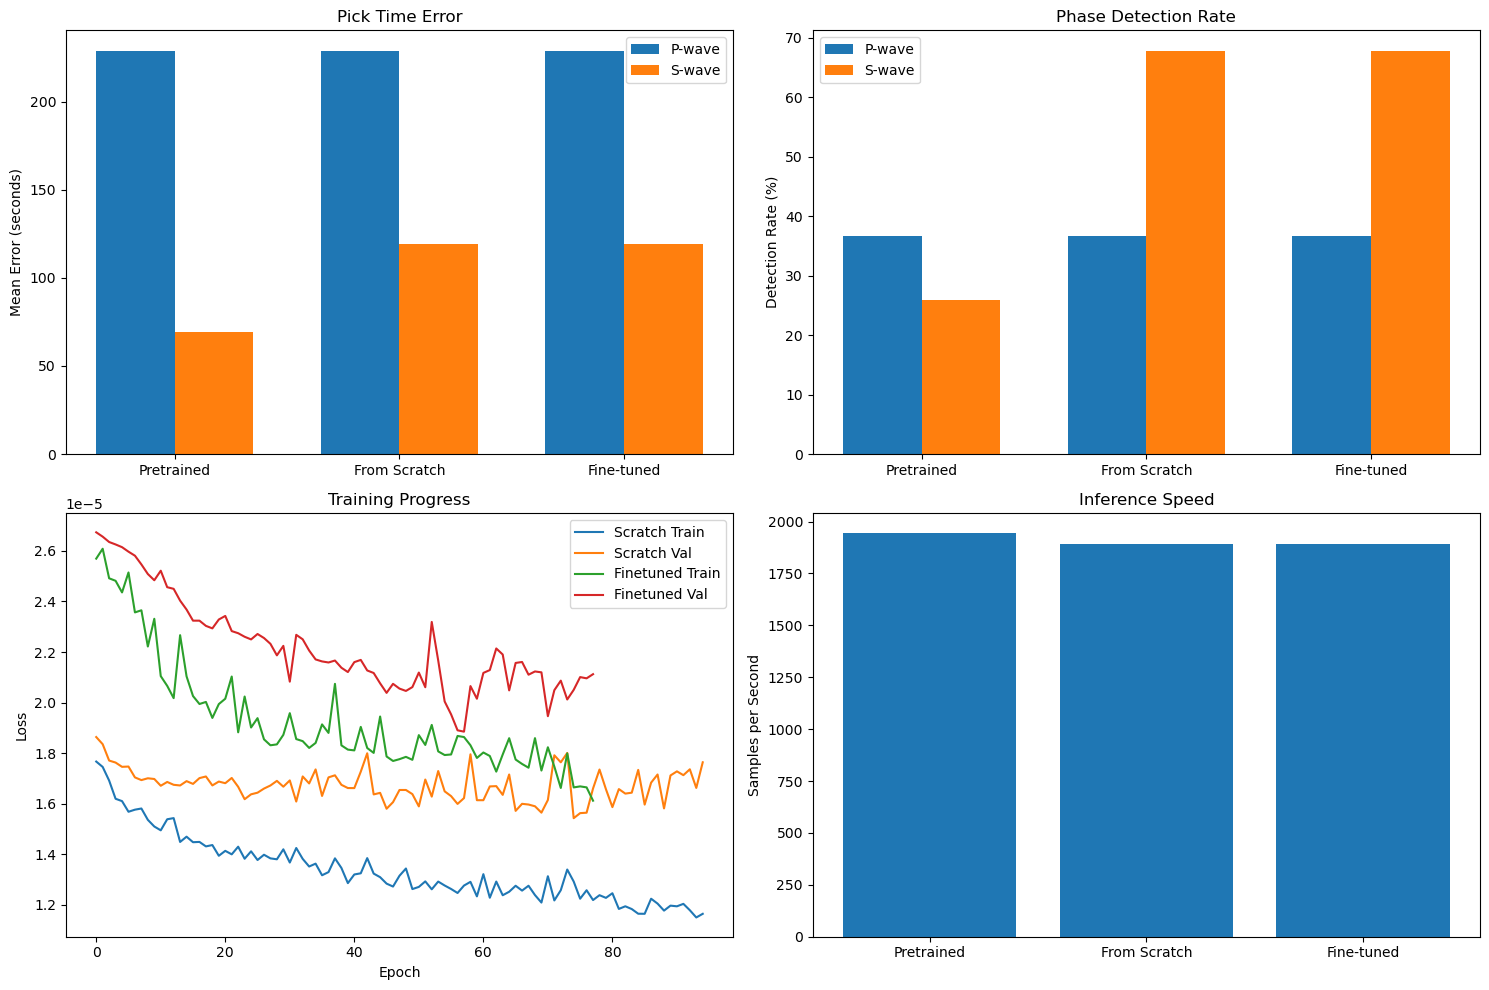

Results exported to output/pickblue


In [15]:
# Run experiment
results_pickblue = run_experiment_pickblue(train_dataset, val_dataset, test_dataset)

# Plot dan export results
plot_results(results_pickblue)
export_results_to_csv(
    results=results_pickblue, output_dir="output/pickblue", experiment_name="pickblue"
)

# EQTransformer

In [ ]:
# from seisbench.models import EQTransformer


# def custom_collate(batch):
#     """Custom collate function untuk DataLoader"""

#     def pad_or_truncate(X, target_length=6000):
#         if X.shape[-1] > target_length:
#             return X[..., :target_length]  # Pangkas hingga panjang 6000
#         elif X.shape[-1] < target_length:
#             pad_length = target_length - X.shape[-1]
#             return F.pad(X, (0, pad_length))  # Tambahkan padding jika kurang dari 6000
#         return X

#     return {
#         "X": torch.stack(
#             [pad_or_truncate(item["X"]) for item in batch]
#         ),  # Pangkas atau padding data X
#         "y": torch.stack(
#             [pad_or_truncate(item["y"]) for item in batch]
#         ),  # Pangkas atau padding data y
#         "station": [item["station"] for item in batch],
#         "event_time": [item["event_time"] for item in batch],
#     }


# def train_model_eqtransformer(
#     model, train_loader, val_loader, epochs=300, device="cuda"
# ):
#     """Training loop untuk EQTransformer dengan loss yang lebih presisi"""
#     optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#     def loss_fn(y_pred_tuple, y_true, eps=1e-5):
#         prob_p = y_pred_tuple[1]
#         prob_s = y_pred_tuple[2]
#         y_pred = torch.stack((prob_p, prob_s), dim=1)

#         # Debug
#         print(f"y_pred (shape): {y_pred.shape}")
#         print(f"y_pred (values): {y_pred}")
#         print(f"y_true (shape): {y_true.shape}")
#         print(f"y_true (values): {y_true}")

#         h = y_true * torch.log(y_pred + eps)
#         h = h.mean(-1).sum(-1)
#         return -h.mean()

#     train_losses = []
#     val_losses = []

#     model = model.to(device)

#     # Untuk tracking best model
#     best_val_loss = float("inf")
#     epochs_no_improve = 0
#     patience = 5  # Early stopping setelah 20 epoch tanpa perbaikan

#     for epoch in range(epochs):
#         # Training
#         model.train()
#         epoch_loss = 0
#         for batch in train_loader:
#             print(f"Shape of X: {batch['X'].shape}")
#             print(f"Shape of y: {batch['y'].shape}")
#             print(f"Values of y: {batch['y']}")
#             break
#             X = batch["X"].float().to(device)
#             y = batch["y"].float().to(device)
#             pred = model(X)

#             loss = loss_fn(pred, y)

#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             epoch_loss += loss.item()

#         avg_train_loss = epoch_loss / len(train_loader)
#         train_losses.append(avg_train_loss)

#         # Validation
#         model.eval()
#         val_loss = 0
#         with torch.no_grad():
#             for batch in val_loader:
#                 X = batch["X"].float().to(device)
#                 y = batch["y"].float().to(device)

#                 pred = model(X)
#                 print(f"Shape of pred[1]: {pred[1].shape}")  # Probabilitas fase P
#                 print(f"Shape of pred[2]: {pred[2].shape}")  # Probabilitas fase S
#                 print(f"Values of pred[1]: {pred[1]}")
#                 print(f"Values of pred[2]: {pred[2]}")

#                 loss = loss_fn(pred, y)
#                 val_loss += loss.item()

#         avg_val_loss = val_loss / len(val_loader)
#         val_losses.append(avg_val_loss)

#         # Early stopping check
#         if avg_val_loss < best_val_loss:
#             best_val_loss = avg_val_loss
#             epochs_no_improve = 0
#         else:
#             epochs_no_improve += 1

#         # Print progress setiap 10 epoch
#         if (epoch + 1) % 10 == 0:
#             print(f"Epoch {epoch+1}/{epochs}")
#             print(f"Train Loss: {avg_train_loss:.8f}")
#             print(f"Val Loss: {avg_val_loss:.8f}")
#             print("-" * 50)

#         # Early stopping
#         if epochs_no_improve == patience:
#             print(f"Early stopping triggered after {epoch+1} epochs")
#             break

#     return train_losses, val_losses


# def evaluate_model_eqtransformer(model, test_loader, device="cuda"):
#     """Evaluasi model EQTransformer dengan metrik yang lebih detail"""
#     model = model.to(device)
#     model.eval()

#     picks_accuracy = {"P": [], "S": []}
#     picks_time_error = {"P": [], "S": []}
#     total_events = 0
#     detected_events = {"P": 0, "S": 0}

#     with torch.no_grad():
#         for batch in test_loader:
#             X = batch["X"].float().to(device)
#             y = batch["y"].float().to(device)

#             pred = model(X)

#             # Handle tuple output
#             prob_p = pred[1]  # Probabilitas fase P
#             prob_s = pred[2]  # Probabilitas fase S

#             for i in range(len(X)):
#                 total_events += 1

#                 true_p = np.where(y[i, 0].cpu().numpy() == 1)[0]
#                 true_s = np.where(y[i, 1].cpu().numpy() == 1)[0]

#                 pred_p = np.where(prob_p[i].cpu().numpy() > 0.5)[0]
#                 pred_s = np.where(prob_s[i].cpu().numpy() > 0.5)[0]

#                 if len(true_p) > 0 and len(pred_p) > 0:
#                     error_samples = abs(true_p[0] - pred_p[0])
#                     picks_accuracy["P"].append(error_samples)
#                     picks_time_error["P"].append(error_samples / 100)
#                     detected_events["P"] += 1

#                 if len(true_s) > 0 and len(pred_s) > 0:
#                     error_samples = abs(true_s[0] - pred_s[0])
#                     picks_accuracy["S"].append(error_samples)
#                     picks_time_error["S"].append(error_samples / 100)
#                     detected_events["S"] += 1

#     return {
#         "error_samples": picks_accuracy,
#         "error_seconds": picks_time_error,
#         "detection_rate": {
#             "P": detected_events["P"] / total_events * 100,
#             "S": detected_events["S"] / total_events * 100,
#         },
#         "median_error": {
#             "P": np.median(picks_time_error["P"]) if picks_time_error["P"] else None,
#             "S": np.median(picks_time_error["S"]) if picks_time_error["S"] else None,
#         },
#     }


# def run_experiment_eqtransformer(
#     train_dataset, val_dataset, test_dataset, device="cuda"
# ):
#     """Menjalankan semua eksperimen EQTransformer"""
#     try:
#         batch_size = 32
#         train_loader = DataLoader(
#             train_dataset,
#             batch_size=batch_size,
#             shuffle=True,
#             collate_fn=custom_collate,
#         )
#         val_loader = DataLoader(
#             val_dataset, batch_size=batch_size, collate_fn=custom_collate
#         )
#         test_loader = DataLoader(
#             test_dataset, batch_size=batch_size, collate_fn=custom_collate
#         )

#         device = "cuda" if torch.cuda.is_available() else "cpu"
#         print(f"Using device: {device}")

#         results = {}
#         inference_times = {}

#         # 1. EQTransformer pretrained tanpa fine-tuning
#         print("\nEvaluating pretrained model...")
#         model_pretrained = EQTransformer.from_pretrained("original")
#         model_pretrained = model_pretrained.to(device)
#         pretrained_accuracy = evaluate_model_eqtransformer(
#             model_pretrained, test_loader, device
#         )
#         inference_times["pretrained"] = measure_inference_time(
#             model_pretrained, test_loader, device
#         )
#         results["pretrained"] = pretrained_accuracy

#         # 2. EQTransformer dari awal dengan data Indonesia
#         print("\nTraining model from scratch...")
#         model_scratch = EQTransformer()
#         model_scratch = model_scratch.to(device)
#         train_losses_scratch, val_losses_scratch = train_model_eqtransformer(
#             model_scratch, train_loader, val_loader, epochs=300, device=device
#         )
#         scratch_accuracy = evaluate_model_eqtransformer(
#             model_scratch, test_loader, device
#         )
#         inference_times["scratch"] = measure_inference_time(
#             model_scratch, test_loader, device
#         )
#         results["scratch"] = scratch_accuracy
#         results["losses"] = {"scratch": (train_losses_scratch, val_losses_scratch)}

#         # 3. EQTransformer pretrained dengan fine-tuning
#         print("\nFine-tuning pretrained model...")
#         model_finetuned = EQTransformer.from_pretrained("original")
#         model_finetuned = model_finetuned.to(device)
#         train_losses_finetuned, val_losses_finetuned = train_model_eqtransformer(
#             model_finetuned, train_loader, val_loader, epochs=300, device=device
#         )
#         finetuned_accuracy = evaluate_model_eqtransformer(
#             model_finetuned, test_loader, device
#         )
#         inference_times["finetuned"] = measure_inference_time(
#             model_finetuned, test_loader, device
#         )
#         results["finetuned"] = finetuned_accuracy
#         results["losses"]["finetuned"] = (train_losses_finetuned, val_losses_finetuned)

#         # Print inference time comparison
#         print("\nInference Time Comparison:")
#         print("-" * 50)
#         for model_name, timing in inference_times.items():
#             print(f"\n{model_name.capitalize()} Model:")
#             print(
#                 f"Total time: {timing['total_time']:.4f} ± {timing['time_std']:.4f} seconds"
#             )
#             print(f"Samples per second: {timing['samples_per_second']:.2f}")
#             print(f"Total samples: {timing['total_samples']}")

#         # Save timing results
#         results["inference_times"] = inference_times

#         return results

#     except Exception as e:
#         print(f"Error in experiments: {str(e)}")
#         raise

In [ ]:
# # Run experiment
# results_eqt = run_experiment_eqtransformer(train_dataset, val_dataset, test_dataset)

# # Plot dan save results
# plot_results(results_eqt)
# export_results_to_csv(
#     results=results_eqt,
#     output_dir="output/eqtransformer",
#     experiment_name="eqtransformer",
# )

# GPD

In [ ]:
# import numpy as np
# import torch
# from seisbench.models import GPD
# from torch.nn.functional import interpolate
# from torch.utils.data import DataLoader


# def custom_collate(batch):
#     """Custom collate function with resampling"""
#     max_samples = 6400  # Ensure compatibility with model
#     resampled_X = []
#     for item in batch:
#         original_shape = item["X"].shape
#         # Reshape to (1, C, L) before interpolate
#         resampled_item = interpolate(
#             item["X"].unsqueeze(0),
#             size=(max_samples,),
#             mode="linear",
#             align_corners=False,
#         ).squeeze(0)
#         resampled_X.append(resampled_item)
#         print(
#             f"Original shape: {original_shape}, Resampled shape: {resampled_item.shape}"
#         )
#     return {
#         "X": torch.stack(resampled_X),
#         "y": torch.stack([item["y"] for item in batch]),
#         "station": [item["station"] for item in batch],
#         "event_time": [item["event_time"] for item in batch],
#     }


# # Training function for GPD model
# def train_model_gpd(model, train_loader, val_loader, epochs=300, device="cuda"):
#     """Training loop for GPD model"""
#     optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#     def loss_fn(y_pred, y_true, eps=1e-10):
#         prob_p, prob_s, prob_n = y_pred[:, 0, :], y_pred[:, 1, :], y_pred[:, 2, :]
#         y_pred = torch.stack((prob_p, prob_s, prob_n), dim=1)
#         h = y_true * torch.log(y_pred + eps)
#         h = h.mean(-1).sum(-1)
#         return -h.mean()

#     train_losses = []
#     val_losses = []

#     model = model.to(device)

#     best_val_loss = float("inf")
#     epochs_no_improve = 0
#     patience = 20

#     for epoch in range(epochs):
#         model.train()
#         epoch_loss = 0
#         for batch in train_loader:
#             X = batch["X"].float().to(device)
#             y = batch["y"].float().to(device)
#             print(f"Input shape before model (training): {X.shape}")
#             pred = model(X)
#             loss = loss_fn(pred, y)

#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             epoch_loss += loss.item()

#         avg_train_loss = epoch_loss / len(train_loader)
#         train_losses.append(avg_train_loss)

#         model.eval()
#         val_loss = 0
#         with torch.no_grad():
#             for batch in val_loader:
#                 X = batch["X"].float().to(device)
#                 y = batch["y"].float().to(device)
#                 print(f"Input shape before model (validation): {X.shape}")
#                 pred = model(X)
#                 loss = loss_fn(pred, y)
#                 val_loss += loss.item()

#         avg_val_loss = val_loss / len(val_loader)
#         val_losses.append(avg_val_loss)

#         if avg_val_loss < best_val_loss:
#             best_val_loss = avg_val_loss
#             epochs_no_improve = 0
#         else:
#             epochs_no_improve += 1

#         if (epoch + 1) % 10 == 0:
#             print(f"Epoch {epoch + 1}/{epochs}")
#             print(f"Train Loss: {avg_train_loss:.8f}")
#             print(f"Val Loss: {avg_val_loss:.8f}")
#             print("-" * 50)

#         if epochs_no_improve == patience:
#             print(f"Early stopping triggered after {epoch + 1} epochs")
#             break

#     return train_losses, val_losses


# # Evaluation function for GPD model
# def evaluate_model_gpd(model, test_loader, device="cuda"):
#     """Evaluation loop for GPD model"""
#     model = model.to(device)
#     model.eval()

#     picks_accuracy = {"P": [], "S": []}
#     picks_time_error = {"P": [], "S": []}
#     total_events = 0
#     detected_events = {"P": 0, "S": 0}

#     with torch.no_grad():
#         for batch in test_loader:
#             X = batch["X"].float().to(device)
#             y = batch["y"].float().to(device)
#             print(f"Input shape before model (evaluation): {X.shape}")

#             pred = model(X)
#             prob_p, prob_s = pred[:, 0, :], pred[:, 1, :]

#             for i in range(len(X)):
#                 total_events += 1

#                 true_p = np.where(y[i, 0].cpu().numpy() == 1)[0]
#                 true_s = np.where(y[i, 1].cpu().numpy() == 1)[0]

#                 pred_p = np.where(prob_p[i].cpu().numpy() > 0.5)[0]
#                 pred_s = np.where(prob_s[i].cpu().numpy() > 0.5)[0]

#                 if len(true_p) > 0 and len(pred_p) > 0:
#                     error_samples = abs(true_p[0] - pred_p[0])
#                     picks_accuracy["P"].append(error_samples)
#                     picks_time_error["P"].append(error_samples / 100)
#                     detected_events["P"] += 1

#                 if len(true_s) > 0 and len(pred_s) > 0:
#                     error_samples = abs(true_s[0] - pred_s[0])
#                     picks_accuracy["S"].append(error_samples)
#                     picks_time_error["S"].append(error_samples / 100)
#                     detected_events["S"] += 1

#     return {
#         "error_samples": picks_accuracy,
#         "error_seconds": picks_time_error,
#         "detection_rate": {
#             "P": detected_events["P"] / total_events * 100,
#             "S": detected_events["S"] / total_events * 100,
#         },
#         "median_error": {
#             "P": np.median(picks_time_error["P"]) if picks_time_error["P"] else None,
#             "S": np.median(picks_time_error["S"]) if picks_time_error["S"] else None,
#         },
#     }


# # Experiment function for GPD model
# def run_experiment_gpd(train_dataset, val_dataset, test_dataset, device="cuda"):
#     """Run experiments for GPD model"""
#     try:
#         batch_size = 32
#         train_loader = DataLoader(
#             train_dataset,
#             batch_size=batch_size,
#             shuffle=True,
#             collate_fn=custom_collate,
#         )
#         val_loader = DataLoader(
#             val_dataset, batch_size=batch_size, collate_fn=custom_collate
#         )
#         test_loader = DataLoader(
#             test_dataset, batch_size=batch_size, collate_fn=custom_collate
#         )

#         print(f"Using device: {device}")

#         results = {}
#         inference_times = {}

#         print("\nEvaluating pretrained model...")
#         model_pretrained = GPD.from_pretrained("original")
#         model_pretrained = model_pretrained.to(device)
#         pretrained_accuracy = evaluate_model_gpd(model_pretrained, test_loader, device)
#         results["pretrained"] = pretrained_accuracy

#         print("\nTraining model from scratch...")
#         model_scratch = GPD()
#         model_scratch = model_scratch.to(device)
#         train_losses_scratch, val_losses_scratch = train_model_gpd(
#             model_scratch, train_loader, val_loader, epochs=300, device=device
#         )
#         scratch_accuracy = evaluate_model_gpd(model_scratch, test_loader, device)
#         results["scratch"] = scratch_accuracy

#         print("\nFine-tuning pretrained model...")
#         model_finetuned = GPD.from_pretrained("original")
#         model_finetuned = model_finetuned.to(device)
#         train_losses_finetuned, val_losses_finetuned = train_model_gpd(
#             model_finetuned, train_loader, val_loader, epochs=300, device=device
#         )
#         finetuned_accuracy = evaluate_model_gpd(model_finetuned, test_loader, device)
#         results["finetuned"] = finetuned_accuracy

#         return results

#     except Exception as e:
#         print(f"Error in experiments: {str(e)}")
#         raise

In [ ]:
# # Run experiment
# results_gpd = run_experiment_gpd(train_dataset, val_dataset, test_dataset)

# # Plot dan save results
# plot_results(results_gpd)
# export_results_to_csv(
#     results=results_gpd, output_dir="output/gpd", experiment_name="gpd"
# )